### Exponential Random Graph Model

#### Import libraries:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from scipy.special import comb

#### Set initial guesses and parameters

In [2]:
alpha = -0.849 # 1.6
gamma = -0.51 # -1.5 1 #newly specified parameter
stop_threshold = 0.01
n = int(12)
p = float(0.15)
Q = 2200
q = 200
Tao = 10
nchoose3 = comb(n,3,exact=True)
m_list=[]
t_list=[]

#### Create an initial graph, either randomly or as an input:

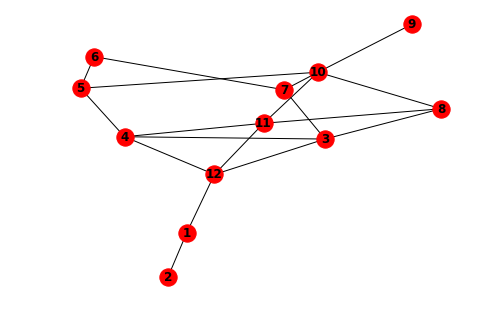

In [23]:
#def create_graph(n,p):
#    try:
#        G.clear()
#    except:
#        pass
#    G = nx.Graph()
#    for q in range(n):
#        G.add_node(q)
#    for i in range(n):
#        for j in range(i+1,n):
#            if random.random()<p:
#                G.add_edge(i,j)
#    return(G)

def create_graph(n,p):
    G=nx.Graph()
    G.add_edges_from([(1,2),(1,12),(3,4),(3,7),(3,8),\
             (3,12),(4,5),(4,11),(4,12),(5,6),\
             (5,10),(6,7),(7,10),(8,10),(8,11),\
             (9,10),(10,11),(11,12)])
    return(G)


#def create_graph(n,p):
#    G_fl = nx.florentine_families_graph()
#    G2=nx.convert_node_labels_to_integers(G_fl)
#    return(G_fl)

G = create_graph(n,p)
nx.draw(G,with_labels=True,font_weight='bold')

G_naught_m = len(G.edges()) # stopping parameter

#### Counting triangles using a NetworkX function that returns the sum of all triangle counts by node, then dividing by 3:

In [24]:
def tri_count(G):
    t_count=0
    for k,v in nx.triangles(G).items():
        t_count+=v
    t_count=t_count/3
    return(t_count)

G_naught_t = tri_count(G) # stopping parameter

print(G_naught_t)
#print(PGprime_PG(200,198,5,6,.4,.8)) # Test calculation

3.0


#### Calculate the probability of $P_{G'}$ relative to $P_G$ using the following equation:
$$\frac{P_{G'}}{P_{G}} = e^{\alpha (m'-m) + \gamma (t' -t)}$$

In [25]:
def PGprime_PG(m,mp,t,tp,alpha,gamma): 
    #links, links prime, triangles, triangles prime, alpha and gamma parameters
    # e ^( (alpha * (m(G')-m(G))) + (gamma * (t(G')-t(G))))
    PGp_PG = math.exp((alpha*(mp-m)+gamma*(tp-t)))
    return(PGp_PG)

temp_m = G.number_of_edges()
temp_mp = temp_m+1
temp_t = tri_count(G)
temp_tp = temp_t+1
PGp_PG = PGprime_PG(temp_m,temp_mp,temp_t,temp_tp,alpha,gamma)
print(PGp_PG)

0.25691756610368544


#### The metropolis step identifies a node at random, then identifies a second node at random that does not equal the first selected node. If there is an edge between them, it is deleted, and if there is not an edge between them, one is added.

#### Alternatively, the binary status of the edge is set to |$a_{ij}$-1| where $a_{ij}$ was the prior state.

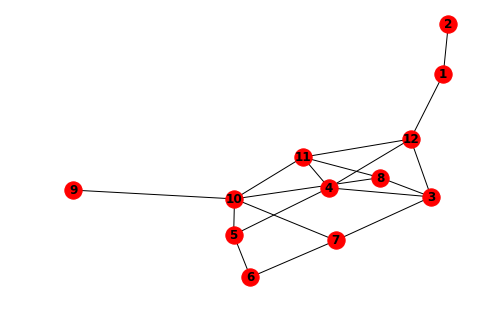

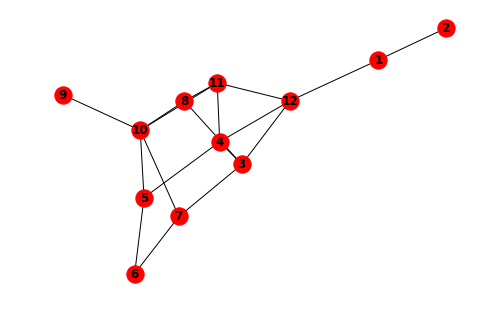

In [26]:
def metropolis_step(G,alpha,gamma):
    Gp = deepcopy(G) # Create G Prime
    i = random.randint(1,len(Gp.nodes)-1)
    j = random.randint(1,len(Gp.nodes)-2)
    if j>=i:
        j+=1
    if j in Gp.neighbors(i):
        Gp.remove_edge(i,j)
    else: Gp.add_edge(i,j)
    """
    # for proofing, uncomment the following to compare the selected nodes
    # and the link lists of G and G' 
    print(i,j)
    print(G.edges())
    print(Gp.edges())
    """
    t,tp = tri_count(G),tri_count(Gp)
    m,mp = G.number_of_edges(),Gp.number_of_edges()
    PGp_PG = PGprime_PG(m,mp,t,tp,alpha,gamma)
    if PGp_PG >= 1:
        #print('Gp')
        return(Gp)
    else:
        accept_proba = random.random()
        if PGp_PG > accept_proba:
            #print('Gp')
            return(Gp)
        else: 
            #print('G')
            return(G)

G = create_graph(n,p)
G_update = metropolis_step(G,alpha,gamma)
plt.figure(1)
nx.draw(G,with_labels=True,font_weight='bold')
plt.figure(2)
nx.draw(G_update,with_labels=True,font_weight='bold')

#### The Markov Chain Monte Carlo simulation iteratively uses Metropolis steps to simulate the given parameters for graphs. 

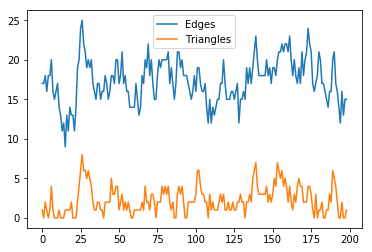

average edges 17.326633165829147
average triangles 2.2964824120603016


In [27]:
def MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma): #change this function to run burn in, then to only update counter as noted below
    G=create_graph(n,p)
    initial_tri = tri_count(G)
    initial_edges = G.number_of_edges()
    count=0
    tri=0
    edge=0
    for a in range(Q): # Change this line to only update the count for cases where a new graph is accepted
        G=metropolis_step(G,alpha,gamma)
        if a > q:
            if a%Tao==0:
                links = G.number_of_edges()
                m_list.append(links)
                triangles = tri_count(G)
                t_list.append(triangles)
                count+=1
                tri+=tri_count(G)
                edge+=G.number_of_edges()
    avg_m = edge/count
    avg_t = tri/count
    return(m_list,t_list,avg_m,avg_t,initial_tri,initial_edges)


m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
plt.plot(m_list,label="Edges")
plt.plot(t_list,label="Triangles")
plt.legend()
plt.show()
print('average edges',avg_m)
print('average triangles',avg_t)

#### The following functions are simple statistical functions needed to calculate a Newton step for the MCMC. 

Average: 
$$\frac{\sum\limits_{i=1}^n x_{i}}{n} $$

Variance:
$$\frac{\sum\limits_{i=1}^n (x_{i}- \bar{x})}{n}$$

Covariance:
$$\frac{\sum\limits_{i=1}^n (x_{i}- \bar{x})(y_{i}- \bar{y})}{n}$$


In [29]:
def average(list_):
    temp=0
    for i in list_:
        temp+=i
    temp=temp/len(list_)
    return(temp)

In [30]:
def variance(list_):
    aver = average(list_)
    var = 0
    #temp_val = 0
    for i in list_:
        temp_val = (i-aver)**2
        var += temp_val
    var=var/len(list_)
    return(var,aver)

In [31]:
def covariance(list1,list2,m_ave,t_ave):
    aver_prod = m_ave*t_ave
    combined = zip(list1,list2)
    temp_list = []
    for i in combined:
        temp_list.append(i[0]*i[1])
    aver_temp = average(temp_list)
    covar = aver_temp-aver_prod
    return(covar)

#### The final component is the Exponential Random Graph Model. This takes the prior input graph and parameters, then iterates through alpha and gamma using the Newton Raphson method until the change in these is less than some specified threshold. At this point, it prints the results of the process.

In [32]:
def ERGM(alpha,gamma,stop_threshold):
    
    stop = 0
    counter =0
    old_alpha =alpha
    old_gamma =gamma
    while stop < 1:
        m_list,t_list =[],[]
        counter+=1
        m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
        old_m_ave,old_t_ave= initial_edges,initial_tri
        m_var,m_ave = variance(m_list)
        t_var,t_ave = variance(t_list)
        covar = covariance(m_list,t_list,m_ave,t_ave)
        D = np.matrix([[m_var,covar],[covar,t_var]])
        Dinv = inv(D)
        mt_array = np.array([m_ave-old_m_ave,t_ave-old_t_ave])
        step = np.dot(Dinv,mt_array)*-1
        alpha += step.item(0)
        gamma += step.item(1)
        #print('identity matrix as proof of inversion')
        #print(np.dot(Dinv,D))
        print("iter:",counter,step.item(0),step.item(1),alpha,gamma)
        if abs((alpha-old_alpha)/alpha) < stop_threshold:
            if abs((gamma-old_gamma)/gamma) < stop_threshold:
                stop  =1
                print("Resulting Alpha and Gamma:",alpha,gamma)
        old_alpha=alpha
        old_gamma=gamma

ERGM(alpha,gamma,stop_threshold)

iter: 1 0.13892972530388714 -0.049351808750189685 -0.7100702746961128 -0.5593518087501896
iter: 2 -0.10613619727225346 0.0938110775926574 -0.8162064719683663 -0.46554073115753225
iter: 3 -0.034194301927934406 -0.15911670967272645 -0.8504007738963006 -0.6246574408302588
iter: 4 0.00925217776269427 0.26845693998439457 -0.8411485961336064 -0.3562005008458642
iter: 5 -0.08310480763967608 0.09286607556498144 -0.9242534037732825 -0.26333442528088274
iter: 6 0.186833522437593 -0.2876087569581016 -0.7374198813356895 -0.5509431822389843
iter: 7 -0.10924170287097287 0.07455576288730249 -0.8466615842066624 -0.47638741935168183
iter: 8 0.11908602061207836 -0.18188424077624857 -0.727575563594584 -0.6582716601279304
iter: 9 -0.03822415972159053 0.2046377845967461 -0.7657997233161745 -0.4536338755311843
iter: 10 0.09182918859083997 -0.06805457647408808 -0.6739705347253345 -0.5216884520052724
iter: 11 -0.0317350422779513 0.0005770007686900849 -0.7057055770032858 -0.5211114512365823
iter: 12 -0.2619647

iter: 93 -0.00031097769661980745 -0.024561734002895862 -0.8298975372838412 -0.4998711018120236
iter: 94 0.07117737276235994 0.03232451087161875 -0.7587201645214813 -0.46754659094040485
iter: 95 0.05711086492423542 -0.14500116489713402 -0.7016092995972458 -0.6125477558375388
iter: 96 -0.02382773162121793 0.4267377725473474 -0.7254370312184637 -0.18580998329019144
iter: 97 -0.20530159678057602 -0.061300677169667805 -0.9307386279990397 -0.24711066045985924
iter: 98 0.13817207332811685 -0.2663357285547133 -0.7925665546709229 -0.5134463890145726
iter: 99 -0.06562257567941493 0.18686345660921833 -0.8581891303503377 -0.3265829324053543
iter: 100 -0.036637503731768356 -0.020806221606216438 -0.894826634082106 -0.3473891540115707
iter: 101 -0.043639675553934054 -0.14454217853067003 -0.9384663096360402 -0.49193133254224075
iter: 102 -0.06728928313063777 0.261898233103574 -1.005755592766678 -0.23003309943866673
iter: 103 0.22284683903673067 -0.1277480252601515 -0.7829087537299473 -0.35778112469881

iter: 183 0.04002586794246403 -0.07391639480603868 -0.7608946132479034 -0.5887480449379943
iter: 184 -0.09721070734545295 0.07662064924046905 -0.8581053205933564 -0.5121273956975252
iter: 185 0.10081197248580415 0.16159261725872906 -0.7572933481075523 -0.3505347784387961
iter: 186 0.045880036816425246 -0.14893090075956558 -0.7114133112911271 -0.4994656791983617
iter: 187 -0.006208758003104796 0.04019278744078701 -0.7176220692942319 -0.4592728917575747
iter: 188 -0.12895286974595147 0.10005528126843019 -0.8465749390401833 -0.35921761048914447
iter: 189 0.03804371528323826 -0.1378565343117531 -0.8085312237569451 -0.49707414480089757
iter: 190 0.013283082993676698 0.1832821326889192 -0.7952481407632683 -0.3137920121119784
iter: 191 -0.19832395522257795 0.01911833572460131 -0.9935720959858463 -0.29467367638737707
iter: 192 0.14970317748030165 -0.18443340872003566 -0.8438689185055446 -0.47910708510741273
iter: 193 -0.07738088947916516 0.39553291448157746 -0.9212498079847098 -0.0835741706258

iter: 273 -0.0796861769276932 0.08939264378288682 -0.9199080331326251 -0.33116676893006086
iter: 274 0.11231356797498261 -0.13458357781139468 -0.8075944651576425 -0.46575034674145555
iter: 275 -0.07347363474641704 -0.03606887523914995 -0.8810680999040595 -0.5018192219806055
iter: 276 -0.037921898911013746 0.006805350439187792 -0.9189899988150733 -0.4950138715414177
iter: 277 0.16446122794980228 -0.1360759425009535 -0.754528770865271 -0.6310898140423712
iter: 278 0.014597662865348138 0.23595920546320162 -0.7399311079999229 -0.3951306085791696
iter: 279 -0.12643188394850263 0.03763134809839164 -0.8663629919484255 -0.35749926048077796
iter: 280 0.058441196916376656 -0.11086818479167268 -0.8079217950320489 -0.46836744527245067
iter: 281 -0.15463220723247859 0.3176880926113174 -0.9625540022645275 -0.15067935266113325
iter: 282 0.2840799780604436 -0.3342444628231684 -0.6784740242040839 -0.48492381548430163
iter: 283 -0.23123090757836526 0.010556193606838404 -0.9097049317824492 -0.47436762187

iter: 363 -0.06780352968133985 -0.08296244819278328 -0.8141399013634976 -0.5716528332052377
iter: 364 0.1447813132751811 0.25930409811454375 -0.6693585880883165 -0.312348735090694
iter: 365 -0.029823938466078975 -0.15355504728175973 -0.6991825265543955 -0.4659037823724537
iter: 366 0.0790213579316385 -0.32454789779742166 -0.620161168622757 -0.7904516801698753
iter: 367 -0.18224308028700276 0.4345876495401763 -0.8024042489097598 -0.355864030629699
iter: 368 0.04414222134356015 -0.14722495007262826 -0.7582620275661996 -0.5030889807023273
iter: 369 -0.05750427648156224 0.097155607418719 -0.8157663040477618 -0.40593337328360835
iter: 370 0.07147882462815126 -0.08505910666391753 -0.7442874794196106 -0.4909924799475259
iter: 371 0.037054217070300016 0.14622236038170683 -0.7072332623493106 -0.34477011956581904
iter: 372 -0.010948411886110843 -0.21101434830564725 -0.7181816742354215 -0.5557844678714663
iter: 373 -0.2143735909187376 0.21624129742955522 -0.9325552651541591 -0.33954317044191107
i

KeyboardInterrupt: 

Altered to have stopping condition <m>-m and <t>-t:

In [34]:
def ERGM(alpha,gamma,G_naught_m,G_naught_t):
    
    stop = 0
    counter =0
    old_t =0
    old_m =0
    while stop < 1:
        m_list,t_list =[],[]
        counter+=1
        m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
        old_m_ave,old_t_ave= initial_edges,initial_tri
        m_var,m_ave = variance(m_list)
        t_var,t_ave = variance(t_list)
        covar = covariance(m_list,t_list,m_ave,t_ave)
        D = np.matrix([[m_var,covar],[covar,t_var]])
        Dinv = inv(D)
        #try:
        #    Dinv = inv(D)
        #except:
        #    Dinv = pinv(D)
        mt_array = np.array([m_ave-G_naught_m,t_ave-G_naught_t])
        step = np.dot(Dinv,mt_array)*-1
        alpha += step.item(0)
        gamma += step.item(1)
        #print('identity matrix as proof of inversion')
        #print(np.dot(Dinv,D))
        print("iter:",counter,step.item(0),step.item(1),alpha,gamma)
        print(m_ave,G_naught_m,t_ave,G_naught_t)
        temp_m_diff = abs(m_ave - G_naught_m)
        temp_t_diff = abs(t_ave - G_naught_t)
        if temp_m_diff < .5:
            if temp_t_diff < .25:
                print(m_ave,G_naught_m,t_ave,G_naught_t)
                print("Resulting Alpha and Gamma:",alpha,gamma)
                stop=1
        old_alpha=alpha
        old_gamma=gamma

#G_naught_m = len(G.edges()) # stopping parameter
#G_naught_t = tri_count(G) # stopping parameter
alpha = -0.849 # 1.6
gamma = -0.51 # -1.5
ERGM(alpha,gamma,G_naught_m,G_naught_t)

iter: 1 0.05206342844229078 0.19730073905113726 -0.7969365715577093 -0.31269926094886275
17.180904522613066 18 2.306532663316583 3.0
iter: 2 -0.0005064775106005271 0.007047763325473666 -0.7974430490683098 -0.30565149762338906
17.969849246231156 18 2.969849246231156 3.0
17.969849246231156 18 2.969849246231156 3.0
Resulting Alpha and Gamma: -0.7974430490683098 -0.30565149762338906
